In [1]:

import os
import gym
import numpy as np

import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from pprint import pprint
from scipy.optimize import minimize
from IPython.display import display

from mdp_extras import vi, OptimalPolicy, padding_trick, UniformRandomCtsPolicy, PaddedMDPWarning, Linear
from mdp_extras.envs import VonMisesNormalBasis, pendulum_obs_to_state

from unimodal_irl import sw_maxent_irl, sw_maxent_irl_modelfree, mean_ci, ile_evd, inner_angle


In [2]:

from gym.wrappers import TimeLimit
from gym.envs.classic_control import PendulumEnv

from stable_baselines3 import DDPG

#env = gym.make("Pendulum-v0")
max_timesteps = 200
env = PendulumEnv()
env = TimeLimit(env, max_timesteps)

# Load trained DDPG policy from rl-baselines3-zoo
model = DDPG.load(os.path.join("rl-trained-agents/ddpg/Pendulum-v0_1/Pendulum-v0.zip"), env=env)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [3]:

# Collect demonstrations from expert policy
num_demos = 20
demos = []
for _ in range(num_demos):
    obs = env.reset()
    traj = []
    while True:
        state = pendulum_obs_to_state(obs)
        action, _ = model.predict(obs)
        traj.append((state, action))
        obs, reward, done, info = env.step(action)
        #env.render()
        if done:
            break
    demos.append(traj)
    #env.close()


[[1.37151059e-04 2.60512667e-01 2.81398862e+01 1.74930180e-01
  3.41116827e-05]
 [2.31260328e-01 6.76203771e-01 2.59998586e-01 1.51190086e-01
  8.24565361e-03]
 [5.44418078e-01 1.68005206e-01 3.72143805e-01 2.68549330e-01
  1.39213610e-01]
 [3.83789219e-01 3.49609855e-01 4.83995883e-01 4.43776477e-01
  1.64711185e-01]
 [1.14459119e-02 3.09310394e-01 3.71177590e-01 3.37854617e-01
  7.77964127e-02]]


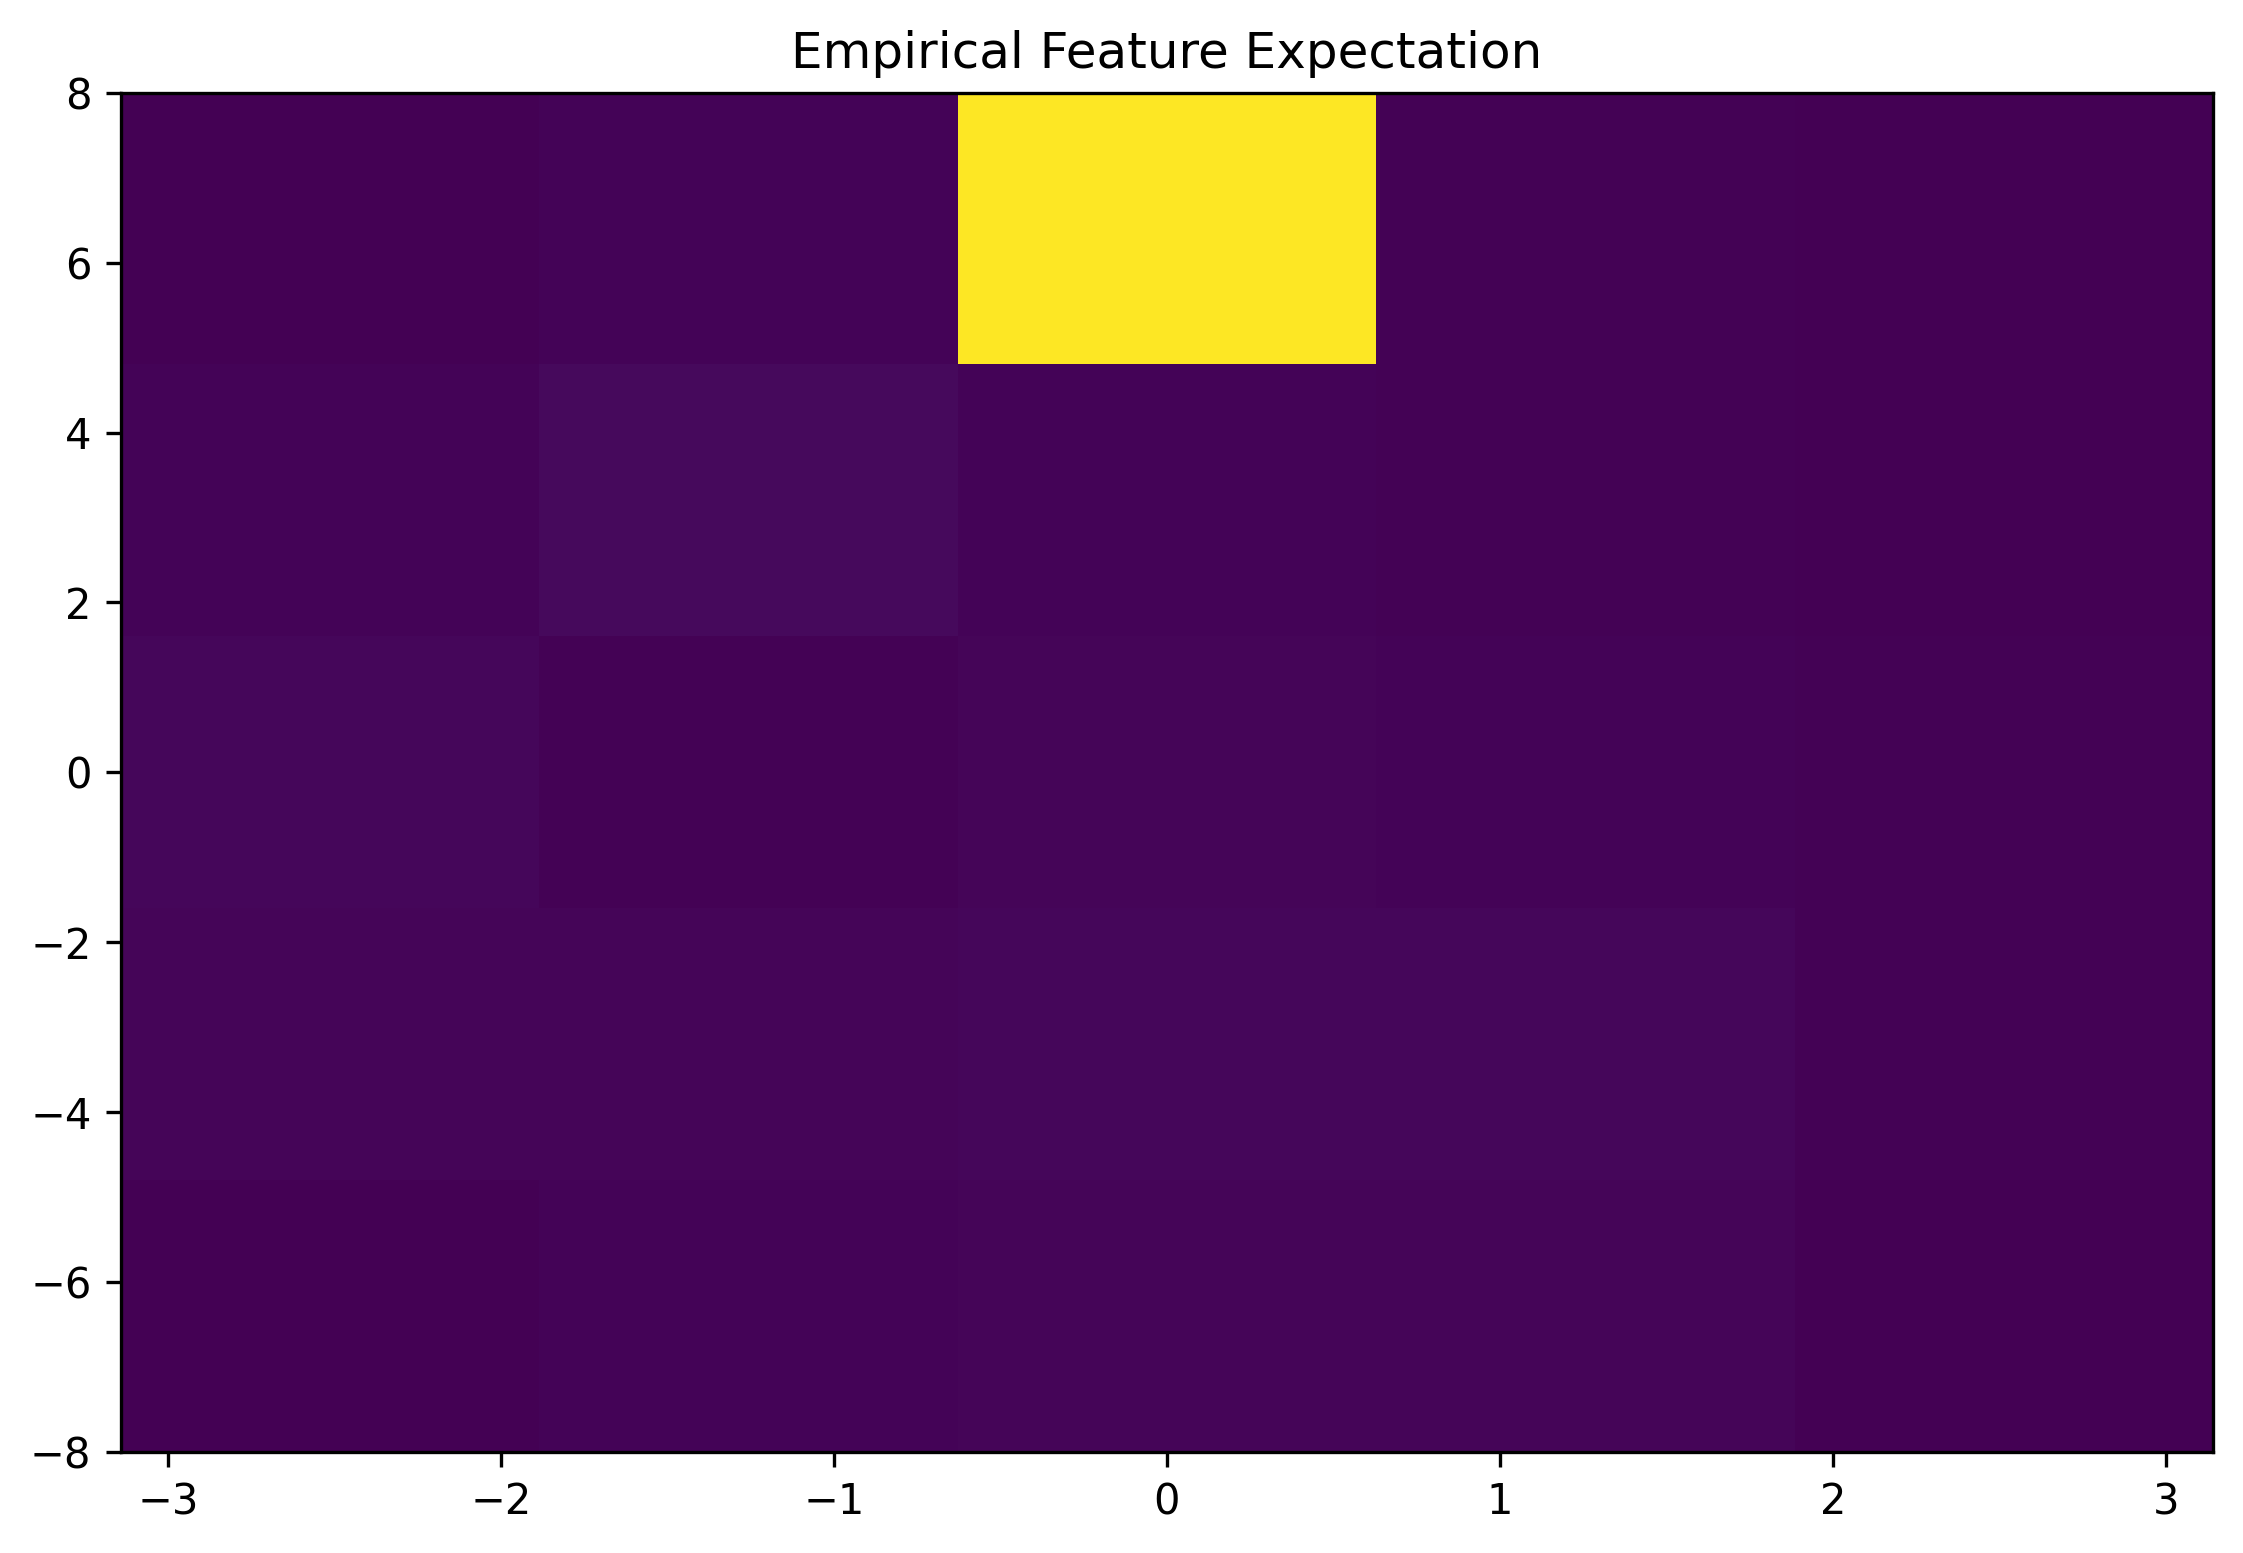

In [4]:
gamma = 0.99

basis_dim = 5
phi = VonMisesNormalBasis(num=basis_dim, kappa=10, std=1.0)

# Visualise feature function
# num = 20
# t = np.linspace(-np.pi, np.pi, num)
# td = np.linspace(-8.0, 8.0, num)

# X, Y = np.meshgrid(t, td)
# Z = np.zeros([X.shape[0], X.shape[1], basis_dim ** 2])
# for id0 in range(X.shape[0]):
#     for id1 in range(X.shape[1]):
#         _x = X[id0, id1]
#         _y = Y[id0, id1]
#         Z[id0, id1] = phi([_x, _y])

# import matplotlib.pyplot as plt

# for _idx in range(basis_dim ** 2):
#     plt.figure()
#     _Z = Z[:, :, _idx]
#     plt.contour(X, Y, _Z)
#     plt.show()
#     plt.close()

phi_bar = phi.demo_average(demos, gamma)

print(phi_bar.reshape(basis_dim, -1))

def viz_soln(x):
    """Visualize a solution vector"""
    plt.figure(figsize=(7, 6), dpi=300)
    sns.set()
    plt.imshow(x.reshape(basis_dim, -1), aspect="auto", extent=(-np.pi, np.pi, -8.0, 8.0))
    plt.colorbar()
    plt.show()

# Visualize expert's feature expectation
viz_soln(phi_bar)


In [5]:

pi_ref = UniformRandomCtsPolicy((-2.0, 2.0))

 # Get importance sampling dataset
pi_ref_demos = []
max_path_length = max_timesteps
num_sampled_paths = 10
for _ in range(num_sampled_paths):
    path_len = np.random.randint(1, high=max_path_length + 1)
    path = []
    obs = env.reset()
    s = pendulum_obs_to_state(obs)
    while len(path) < path_len - 1:
        a = pi_ref.predict(s)[0]
        path.append((s, a))
        obs, r, done, _ = env.step(a)
        s = pendulum_obs_to_state(obs)
    path.append((s, None))
    pi_ref_demos.append(path)

# Pre-compute sampled path feature expectations
pi_ref_demo_phis_precomputed = [
    phi.onpath(p, gamma)
    for p in pi_ref_demos
]


      fun: 219.59309800973244
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.10626221e-04,  1.88205719e-01, -2.37401428e+01,  8.44902039e-01,
        1.06620789e-03,  1.30294800e-01,  4.73939896e-01,  3.03993225e-01,
        1.46773529e+00,  1.91612244e-01,  5.08764267e-01,  1.17923737e-01,
        1.76383972e-01, -2.53582001e-02,  1.09270859e+00,  7.13771820e-01,
       -4.97131348e-02,  4.10079956e-04, -2.54730225e-01,  8.86425018e-01,
        1.86866760e-01,  1.10196877e+00,  1.12230301e-01,  4.98119354e-01,
        3.96692276e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1040
      nit: 31
     njev: 40
   status: 0
  success: True
        x: array([-0.05517069, -1.        ,  1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        ,  1.        , -1.        ,
       -1.        ,  1.        ,  0.58257734,  1.        , -1.   

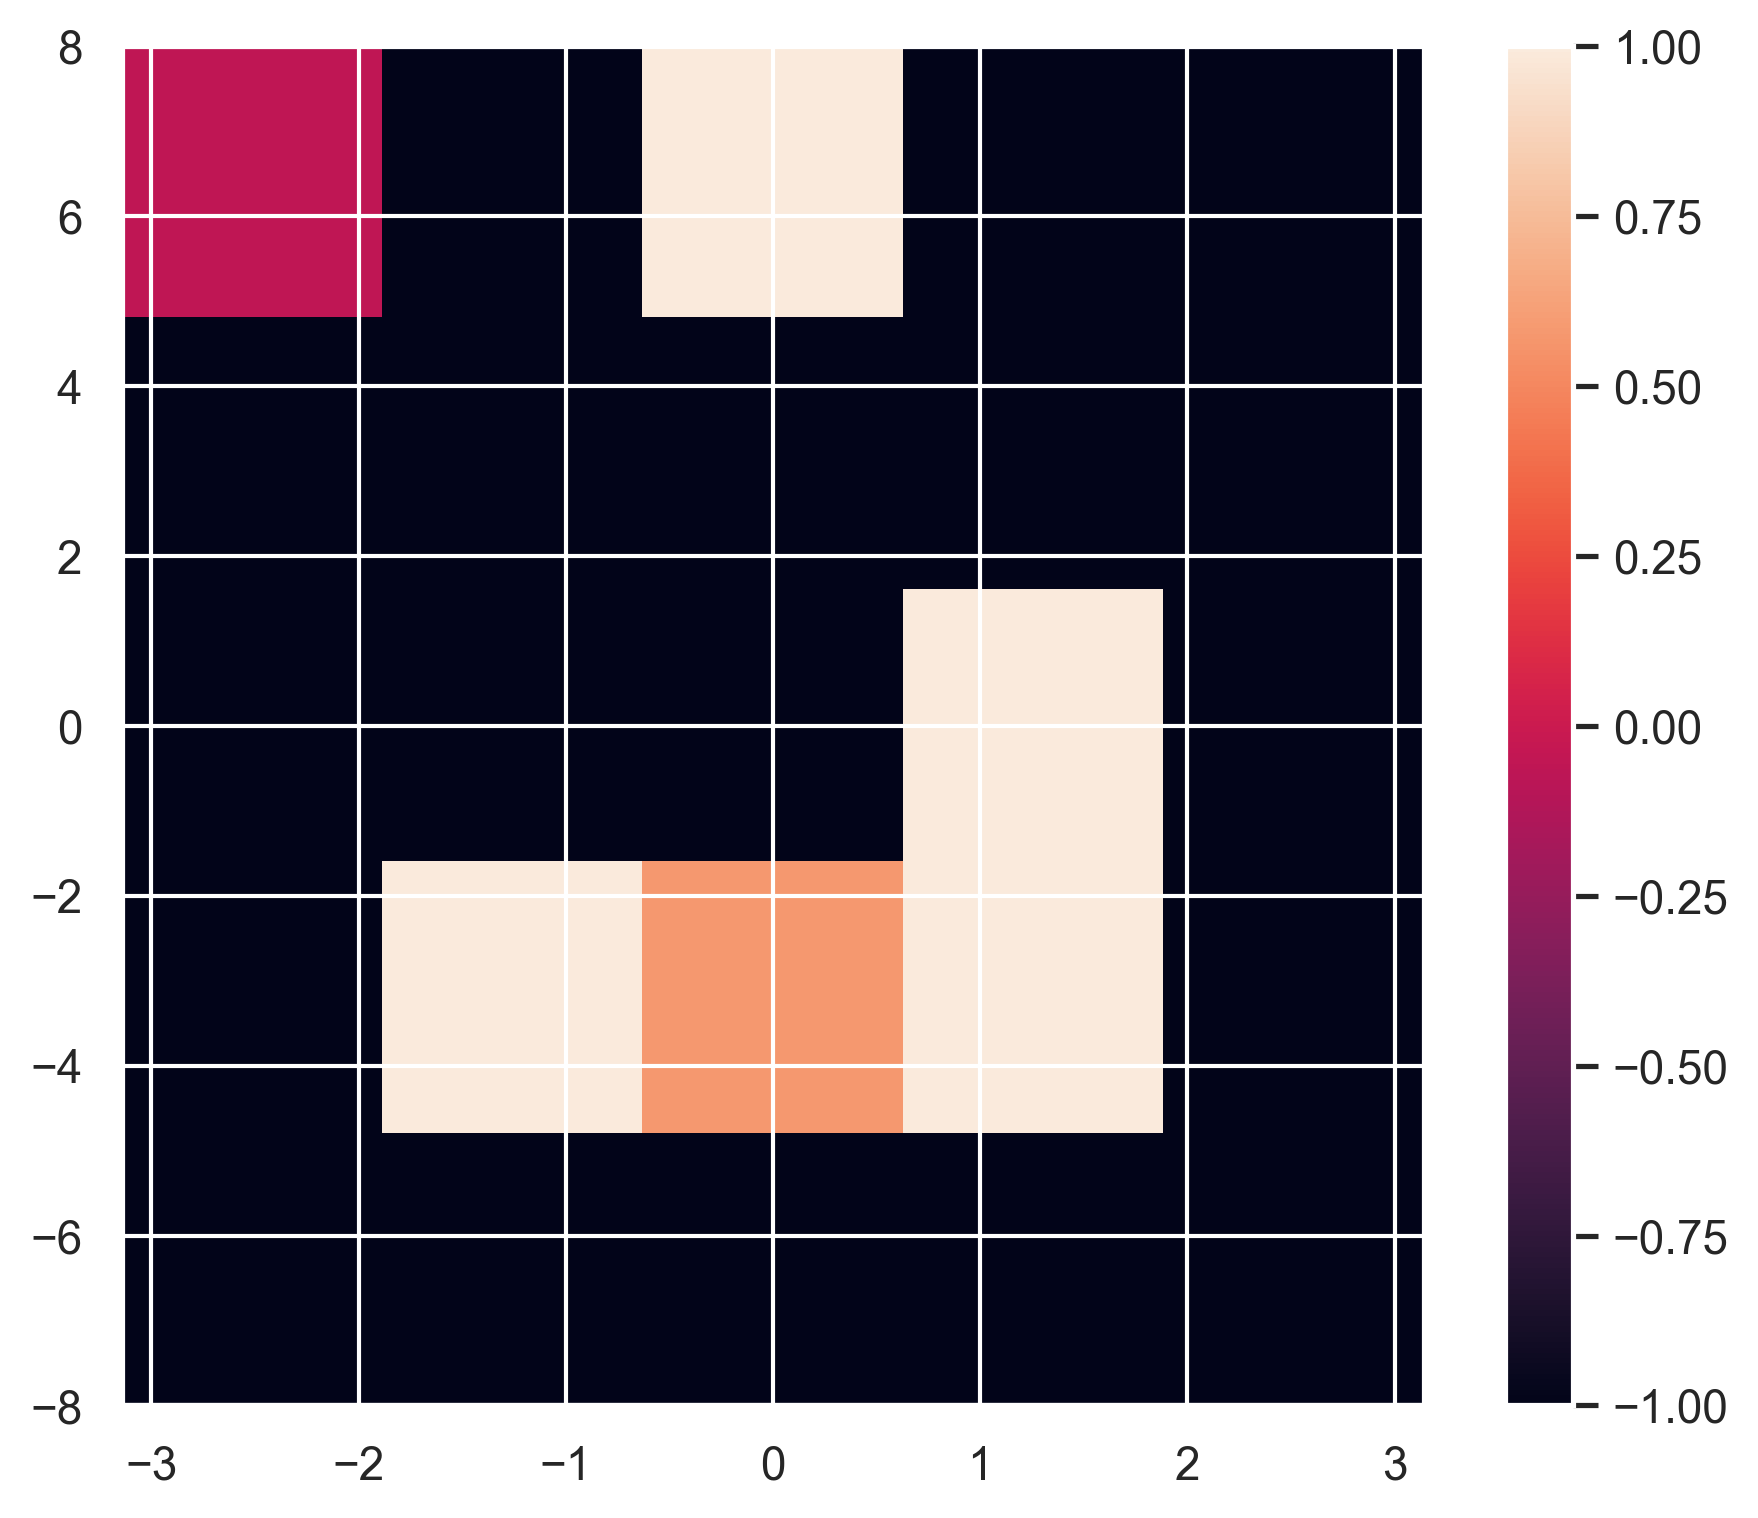

In [24]:

x0 = np.zeros(len(phi))

## Nelder Mead doesn't work - the scipy implementation doesn't support bounds or callback termination signals
res = minimize(
    sw_maxent_irl_modelfree,
    x0,
    args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, True, pi_ref_demo_phis_precomputed),
    method='L-BFGS-B',
    jac='2-point',
    bounds=[(-1, 1) for _ in range(len(phi))],
    options=dict(disp=True)
)

print(res)
viz_soln(res.x)


      fun: 219.59414402245943
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.13686838e-04,  1.88254034e-01, -2.37396533e+01,  8.45014365e-01,
        1.06865627e-03,  1.30330590e-01,  4.74065584e-01,  3.04049762e-01,
        1.46791307e+00,  1.91633375e-01,  5.08876494e-01,  1.17682929e-01,
        1.75799641e-01, -2.55312215e-02,  1.09284599e+00,  7.13890810e-01,
       -4.99682071e-02, -1.08002495e-04, -2.54917153e-01,  8.86538483e-01,
        1.86889792e-01,  1.10212567e+00,  1.12277120e-01,  4.98212669e-01,
        3.96744324e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 754
      nit: 24
     njev: 29
   status: 0
  success: True
        x: array([-0.00258916, -1.        ,  1.        , -1.        , -0.02497003,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        ,  1.        , -1.        ,
       -1.        ,  1.        ,  0.58257958,  1.        , -1.    

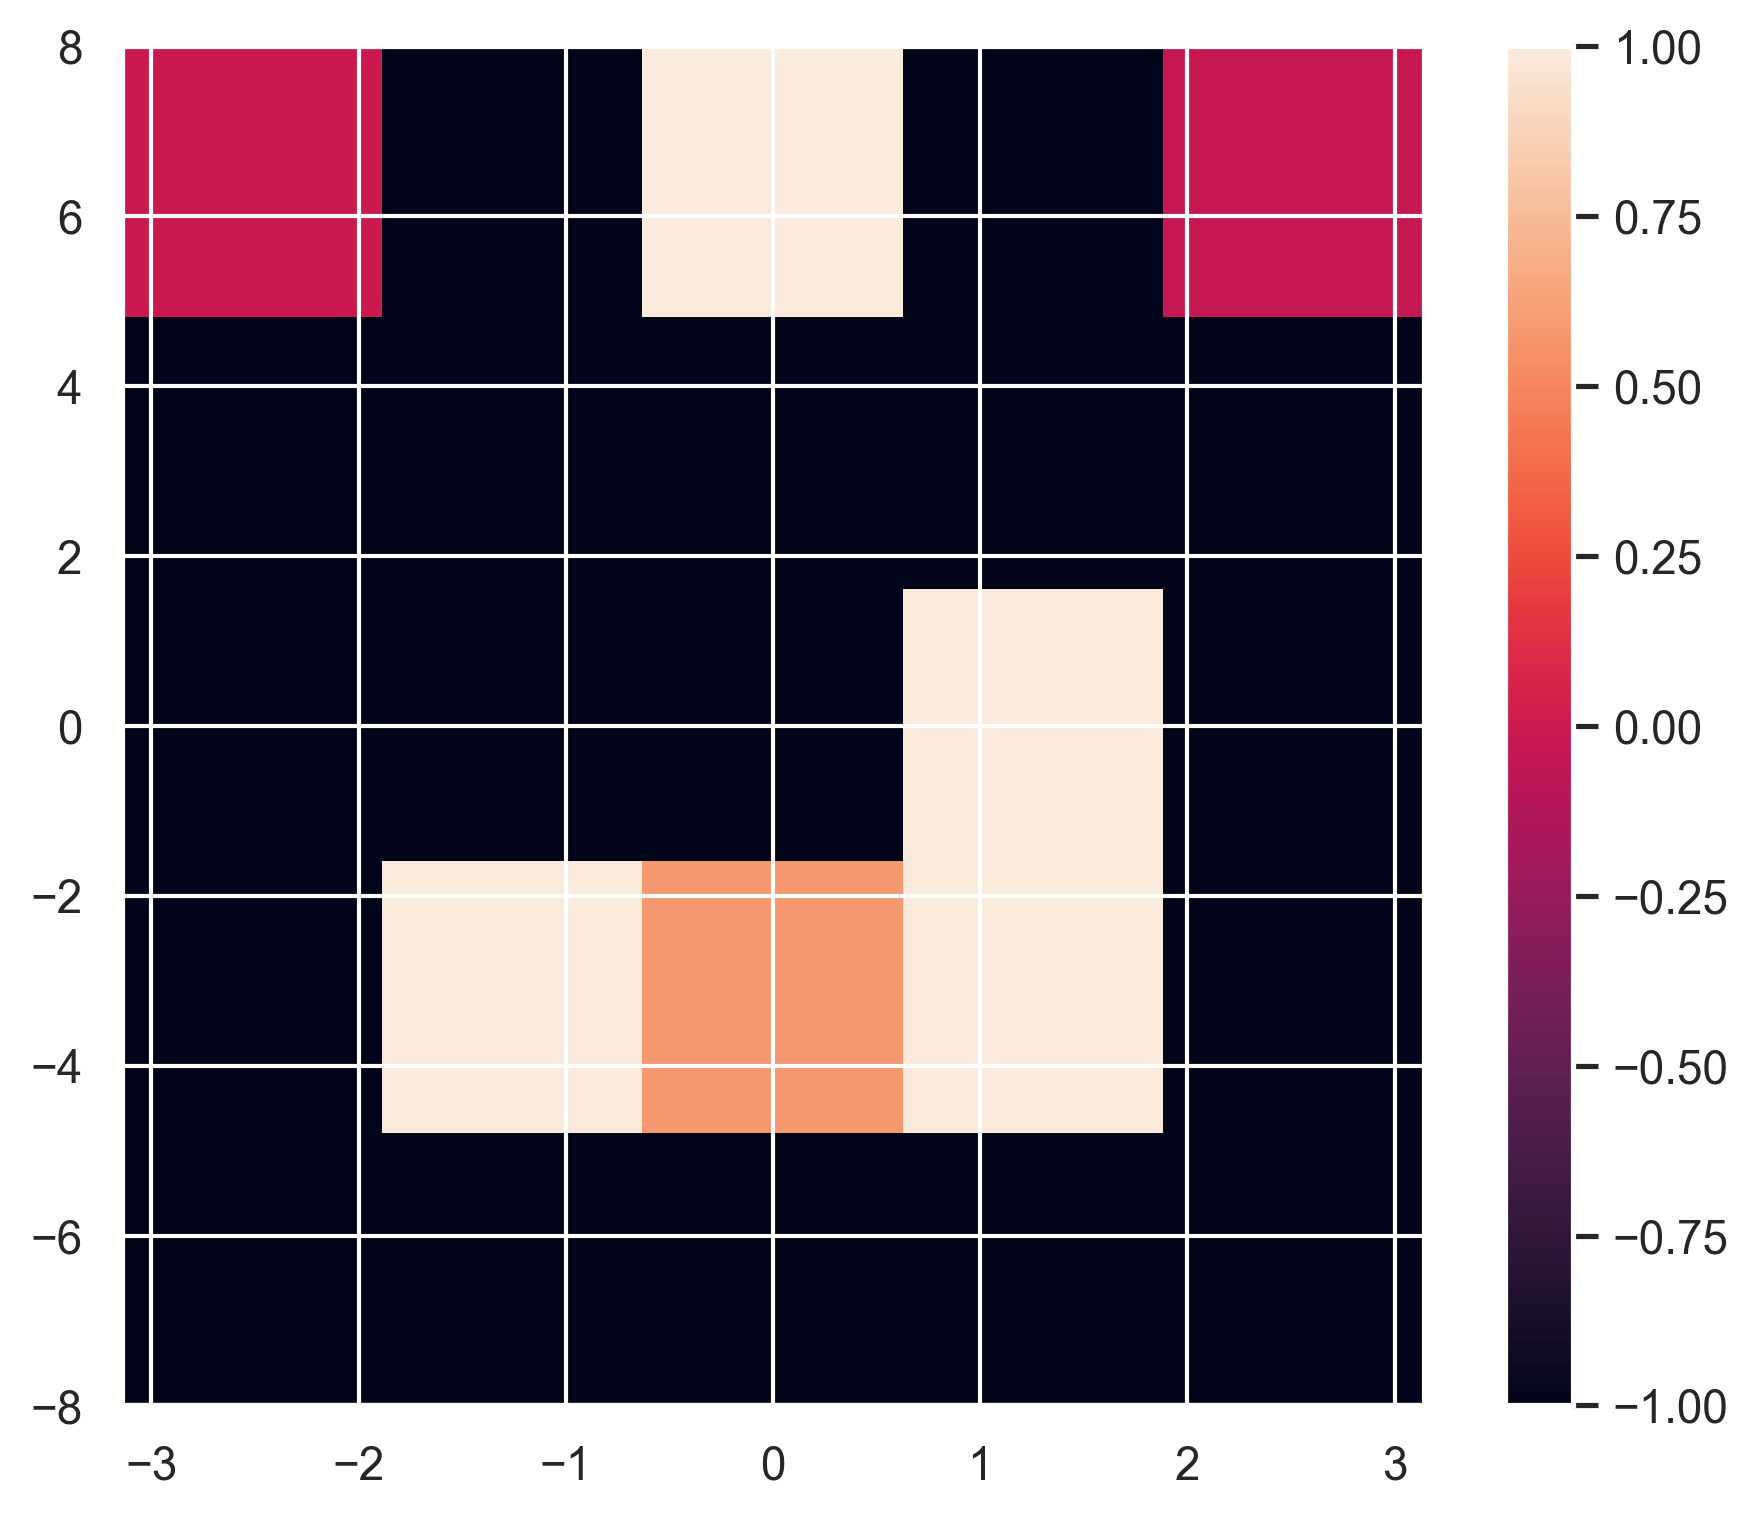

In [25]:

x0 = np.zeros(len(phi))

## Nelder Mead doesn't work - the scipy implementation doesn't support bounds or callback termination signals
res = minimize(
    sw_maxent_irl_modelfree,
    x0,
    args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, True, pi_ref_demo_phis_precomputed),
    method='L-BFGS-B',
    jac='32-point',
    bounds=[(-1, 1) for _ in range(len(phi))],
    options=dict(disp=True)
)

print(res)
viz_soln(res.x)


In [13]:

import cma

x0 = np.zeros(len(phi))
x, es = cma.fmin2(
    sw_maxent_irl_modelfree,
    x0,
    0.5,
    args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, True, pi_ref_demo_phis_precomputed),
    options=dict(bounds=[-1.0, 1.0])
)

print(x.reshape(basis_dim, -1))

viz_soln(x)


(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 25 (seed=284212, Mon Jun 21 01:26:04 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 2.395482336295536e+02 1.0e+00 4.67e-01  5e-01  5e-01 0:00.2
    2     26 2.338369776146693e+02 1.1e+00 4.57e-01  5e-01  5e-01 0:00.3
    3     39 2.301867639921228e+02 1.1e+00 4.43e-01  4e-01  4e-01 0:00.4
   26    338 2.259836270177454e+02 1.8e+00 4.57e-01  4e-01  5e-01 0:03.4
   60    780 2.226393793826850e+02 2.5e+00 2.49e-01  1e-01  3e-01 0:07.5
   97   1261 2.208431478685566e+02 3.5e+00 1.96e-01  8e-02  2e-01 0:12.6
  100   1300 2.210529894570626e+02 3.6e+00 1.77e-01  7e-02  2e-01 0:13.1
  148   1924 2.198892338867708e+02 5.2e+00 4.39e-02  1e-02  5e-02 0:20.2
  200   2600 2.196590300806527e+02 8.5e+00 3.98e-02  9e-03  6e-02 0:28.0
  264   3432 2.195964161322503e+02 1.5e+01 1.46e-02  2e-03  3e-02 0:37.0
  300   3900 2.195933768213534e+02 1.6e+01 3.80e-03  6e-04  7e-03 0:42.0
  383   4979 2.195931515195979e+0